In [1]:
import numpy as np
import pandas as pd
import math
import time
import re
import os
from skimage import util
from scipy.io import wavfile
from scipy import signal
from scipy import stats
import xarray as xr

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
netcdf_path = 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets'

In [4]:
path_names = []
files = os.listdir(netcdf_path)
for file in files: 
        path_names.append(netcdf_path + "/" + file)

path_names

['C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/533_xr_Dataset.nc',
 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/534_xr_Dataset.nc',
 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/535_xr_Dataset.nc',
 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/542_xr_Dataset.nc',
 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/543_xr_Dataset.nc',
 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/554_xr_Dataset.nc',
 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/555_xr_Dataset.nc',
 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/559_xr_Dataset.nc',
 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/600_xr_Dataset.nc']

In [89]:
data = xr.open_dataset(path_names[1])
data

<xarray.Dataset>
Dimensions:                        (freq: 257, slices: 26666, times: 55)
Coordinates:
  * freq                           (freq) float64 0.0 488.3 ... 1.25e+05
  * times                          (times) float64 0.000256 0.000704 ... 0.02445
  * slices                         (slices) float64 0.0 22.5 ... 5.999e+05 6e+05
Data variables:
    __xarray_dataarray_variable__  (slices, freq, times) float32 ...

In [90]:
slice_bbc = data['__xarray_dataarray_variable__'].sel(slices=535702.5)
slice_noise = data['__xarray_dataarray_variable__'].sel(slices=1170.0)
slice_slug = data['__xarray_dataarray_variable__'].sel(slices=52357.5)
times = data['times'].values
freqs = data['freq'].values

In [70]:
max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)

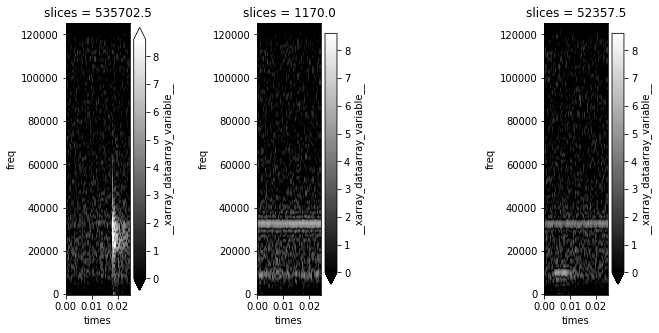

In [83]:
plt.figure(figsize=(10,5))
plt.subplot(1, 6, 1)
xr.ufuncs.log(slice_bbc).plot(cmap='gray', vmin=min_value*0, vmax=max_value*.7)
plt.subplot(1, 6, 3)
xr.ufuncs.log(slice_noise).plot(cmap='gray', vmin=min_value*0, vmax=max_value*.7)
plt.subplot(1, 6, 6)
xr.ufuncs.log(slice_slug).plot(cmap='gray', vmin=min_value*0, vmax=max_value*.7)
plt.show()

Try to use iirnotch filter for noise band

In [149]:
fs = 250000  # Sample frequency (Hz)
f0 = 33000  # Frequency to be removed from signal (Hz)
w0 = f0/(fs/2)  # Normalized Frequency
bw = -3
Q = w0/bw  # Quality factor
# Design notch filter
b, a = signal.iirnotch(w0, Q)
output_signal = signal.filtfilt(b, a, slice_noise)
output_signal

array([[ 0.02267666,  0.02267666,  0.02267666, ...,  0.02267666,
         0.02267666,  0.02267666],
       [ 0.0016911 ,  0.0016911 ,  0.0016911 , ...,  0.0016911 ,
         0.0016911 ,  0.0016911 ],
       [ 0.00937749,  0.00937749,  0.00937749, ...,  0.00937749,
         0.00937749,  0.00937749],
       ...,
       [-0.00863755, -0.00863755, -0.00863755, ..., -0.00863755,
        -0.00863755, -0.00863755],
       [ 0.01828396,  0.01828396,  0.01828396, ...,  0.01828396,
         0.01828396,  0.01828396],
       [ 0.01287533,  0.01287533,  0.01287533, ...,  0.01287533,
         0.01287533,  0.01287533]])

C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


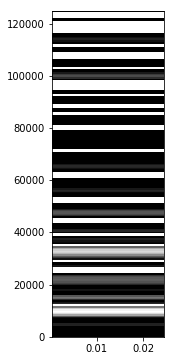

In [150]:
plt.figure(figsize=(2,6))
plt.pcolormesh(times, freqs, np.log(output_signal), cmap='gray', vmin=0)
plt.show()

Use PCA for noise band

In [159]:
noise_df = pd.DataFrame(data = slice_noise.values, index=freqs, columns = times)
noise_df.head()

,0.000256,0.000704,0.001152,0.0016,0.002048,0.002496,0.002944,0.003392,0.00384,0.004288,0.004736,0.005184,0.005632,0.00608,0.006528,0.006976,0.007424,0.007872,0.00832,0.008768,0.009216,0.009664,0.010112,0.01056,0.011008,0.011456,0.011904,0.012352,0.0128,0.013248,0.013696,0.014144,0.014592,0.01504,0.015488,0.015936,0.016384,0.016832,0.01728,0.017728,0.018176,0.018624,0.019072,0.01952,0.019968,0.020416,0.020864,0.021312,0.02176,0.022208,0.022656,0.023104,0.023552,0.024,0.024448
0.00000,0.039378,0.118557,0.433607,1.109671,1.482538,0.604877,0.000583,0.000058,0.178539,0.000175,0.149129,0.405024,0.094945,0.057801,0.253687,0.003734,0.354179,0.324087,0.343699,0.080579,1.317067,0.038172,0.000386,0.042513,0.056413,0.004807,0.333008,0.039870,0.228964,0.081063,0.020514,0.207858,0.000435,0.000277,0.847426,0.688576,0.056265,0.043584,0.000826,0.001253,2.207461,0.050767,0.248672,0.073460,0.047651,0.573688,0.000652,0.642490,0.372544,0.015631,0.053813,0.547210,0.036904,0.517007,0.043576
488.28125,0.024568,0.175568,1.503608,1.804409,2.670056,1.029272,0.048122,0.001097,0.228885,0.043276,0.325932,0.645213,0.115520,0.413248,0.518052,0.048380,0.466893,0.452230,0.552884,0.303796,2.117155,0.240255,0.055755,0.055692,0.114202,0.105184,0.730448,0.058028,0.746733,0.196774,0.082044,0.397631,0.213150,0.151793,1.597987,1.157948,0.079571,0.102116,0.095766,0.200013,3.780300,0.200267,0.431549,0.145121,0.028585,0.956909,0.011975,1.221784,0.696555,0.149592,0.120906,1.092120,0.279943,0.929967,0.190320
976.56250,0.083464,0.045250,2.459425,0.839884,1.884058,0.597404,0.161682,0.002028,0.035247,0.134433,0.363046,0.273530,0.025003,0.984404,0.460454,0.229885,0.103077,0.106481,0.270373,0.422627,0.959636,0.389638,0.159090,0.028647,0.179448,0.388592,0.664093,0.150915,1.216170,0.237071,0.220131,0.351611,0.553313,0.623276,1.270963,0.656747,0.018925,0.141738,0.234862,0.743817,2.233634,0.420758,0.280614,0.152406,0.106230,0.520038,0.025927,1.014588,0.534930,0.353394,0.161488,1.032245,0.735402,0.671773,0.537697
1464.84375,0.473842,0.014696,2.224816,0.071110,0.921628,0.192911,0.262540,0.047344,0.139016,0.191070,0.287938,0.028527,0.109793,1.186554,0.383993,0.506744,0.181909,0.011334,0.065790,0.193720,0.133824,0.237034,0.214444,0.106089,0.341719,0.779213,0.262591,0.537851,1.229688,0.178513,0.475512,0.296684,0.548746,1.166981,0.759112,0.227762,0.037651,0.186289,0.216973,1.473697,0.667942,0.590533,0.146818,0.197198,0.613162,0.154098,0.035679,0.720095,0.269556,0.394781,0.227538,0.811239,1.007158,0.388650,1.046172
1953.12500,0.841062,0.278683,0.945975,0.275096,0.218213,0.066678,0.271274,0.231185,0.634578,0.157948,0.071566,0.280833,0.317361,0.761416,0.619218,0.577843,0.638761,0.181203,0.021185,0.036779,0.537508,0.389356,0.213726,0.300127,0.434347,1.043343,0.011530,1.071492,0.748228,0.047761,0.821477,0.252476,0.223077,1.169427,0.387283,0.149536,0.245674,0.204137,0.113833,2.141373,0.010770,0.593557,0.129830,0.282229,1.129256,0.110545,0.116892,0.555450,0.036504,0.249559,0.306075,0.435693,0.775599,0.195832,1.345846


In [313]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=30)
W = nmf.fit_transform(noise_df)
H = nmf.components_

<function matplotlib.pyplot.show(*args, **kw)>

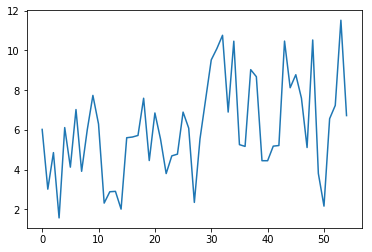

In [309]:
plt.plot(nmf.components_[0].T)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

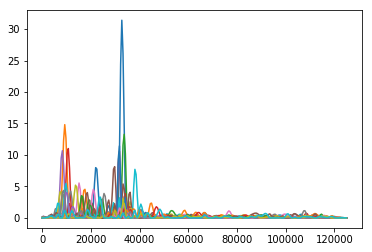

In [314]:
plt.plot(freqs, W)
plt.show

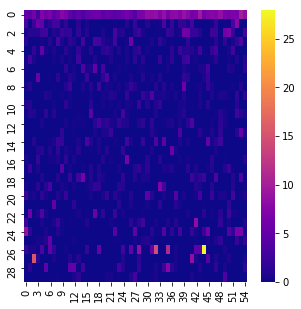

In [361]:
plt.figure(figsize=(5,5))
#plt.imshow(nmf.components_, cmap='plasma')
sns.heatmap(H, cmap='plasma')

In [367]:
M = W[:, 5:]@H[5:, :]

In [357]:
l = list(range(0,30))
l_short = l.remove(1)

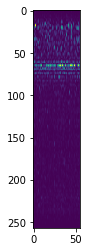

In [369]:
plt.imshow(M)
plt.show()

Create data frame of annotation info

In [23]:
features_path = 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/annot_features_full.csv'
annot_features_data = pd.read_csv(features_path)
annot_features_full = pd.DataFrame(data = annot_features_data)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.head()

(1084, 13)
Int64Index([], dtype='int64')


,Unnamed: 0,Animal,Group,Annotation,time_stamp,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
0,0,533,5,low slug,46305.0,32714.904,0.368722,39977.724643,9966.541464,2.313672,9.578221,0.000271,37978.838411
1,1,533,5,low slug,149692.5,43037.465,0.306856,37931.297975,20543.321215,4.308415,22.308306,-0.000239,36034.733076
2,2,533,5,low slug,243157.5,270193.530,0.062226,11483.575333,37201.715521,6.940257,50.135018,-0.001537,10909.396566
3,3,533,5,low slug,243270.0,63014.450,0.232295,32242.081971,21947.090189,5.325133,33.372614,-0.000671,30629.977872
4,4,533,5,low multi,295560.0,74933.164,0.206291,17095.059221,11740.918797,5.372725,34.224633,-0.001093,16240.306260


In [26]:
annot_features_full = annot_features_full[annot_features_full['Annotation'] != 'noise']

In [32]:
annot_features_full.Annotation.value_counts()

rand_noise    900
low slug       62
low multi      17
bbc            16
high slug       9
high multi      5
Name: Annotation, dtype: int64

In [33]:
annot_features_full.columns.values

array(['Unnamed: 0', 'Animal', 'Group', 'Annotation', 'time_stamp',
       'power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll'], dtype=object)

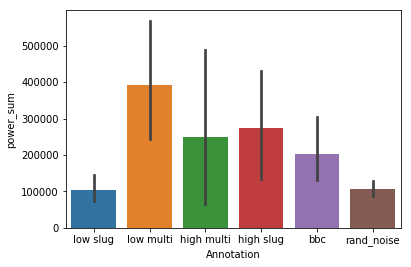

In [27]:
sns.barplot(x="Annotation", y="power_sum", data=annot_features_full)

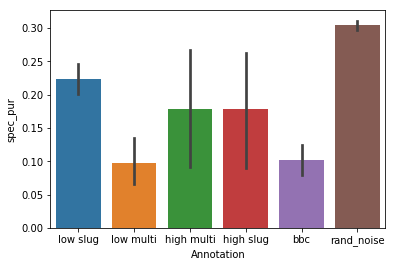

In [28]:
sns.barplot(x="Annotation", y="spec_pur", data=annot_features_full)

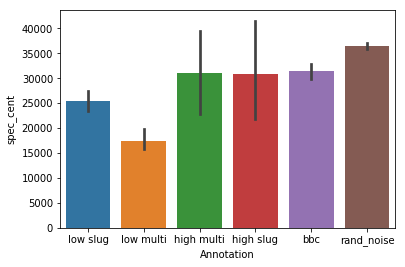

In [29]:
sns.barplot(x="Annotation", y="spec_cent", data=annot_features_full)

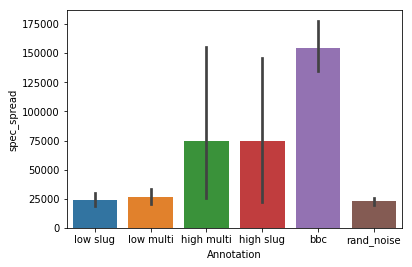

In [30]:
sns.barplot(x="Annotation", y="spec_spread", data=annot_features_full)

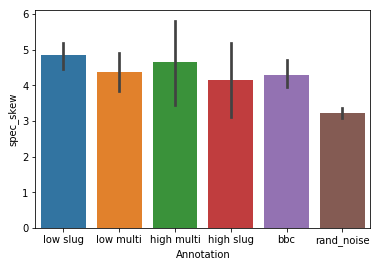

In [31]:
sns.barplot(x="Annotation", y="spec_skew", data=annot_features_full)

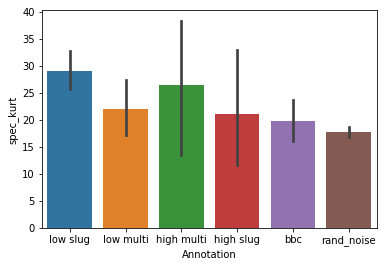

In [77]:
sns.barplot(x="Annotation", y="spec_kurt", data=annot_features_full)

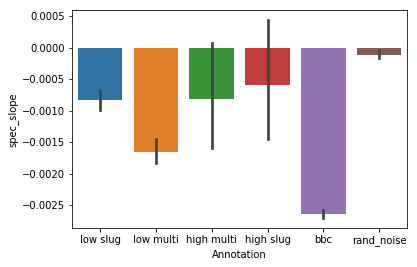

In [78]:
sns.barplot(x="Annotation", y="spec_slope", data=annot_features_full)

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(yes_spec_purs, color='green', bins = 500)
plt.hist(no_spec_purs, color='red', alpha = .5, bins = 500)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(yes_sums, color='green', bins = 500)
plt.hist(no_sums, color='red', alpha = .5, bins = 500)
plt.show()

In [ ]:
data_no['slices'].values[0]

In [ ]:
spec_slice = data_yes.sel(slices = data_yes['slices'].values[0])['__xarray_dataarray_variable__'].values
spec_slice.mean()

In [ ]:
data_yes['slices']

In [ ]:
spec_slice = data.sel(slices = 45.0)['__xarray_dataarray_variable__'].values
spec_slice.sum()

In [ ]:
x = data['__xarray_dataarray_variable__']
x[0]

In [ ]:
data.sel()

In [ ]:
spec_slice.mean(dim='times')
x

In [ ]:
spec_slice = data.sel(slices = 90.0)
spec_slice

In [ ]:
data.to_pandas()

In [ ]:
data.sel(freq=slice(0,20000))[4,:,:].plot()